In [1]:
%pylab inline

from __future__ import print_function
from __future__ import division

import pandas
import numpy
import matplotlib
import seaborn
import sklearn
import sys

from matplotlib import pyplot

Populating the interactive namespace from numpy and matplotlib


In [2]:
def index_merge(a, b):
    return a.merge(b, left_index = True, right_index = True)
pandas.DataFrame.index_merge = index_merge

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5

# Limiting memory use

In [3]:
import resource

# Limit the memory usage to 6GByte.
resource.setrlimit(resource.RLIMIT_AS, (6e9, 6e9))

# Merging

In [47]:
subject_words = pandas.read_csv('dev/subject_word_features.csv', index_col = 'num')
body_words = pandas.read_csv('dev/body_word_features.csv', index_col = 'num')
features = features.index_merge(subject_words).index_merge(body_words)

In [ ]:
features.to_csv('dev/features.csv', index = True, header = True)

# Getting Features

In [4]:
features = pandas.read_csv('dev/features.csv', index_col = 'num').sample(frac = 1, random_state = 0)

# Testing different methods

In [5]:
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier

In [6]:
X = features.drop('spam', axis = 1)
y = features.spam
%xdel features

In [7]:
word_bag = X.columns[X.columns.str.contains('_contains_')]
existence = X.columns[X.columns.str.contains('_exists')]
categorization = X.columns[X.columns.str.contains('=')]

features = ['_length', '_words', '_fields', '_avgWordLength', '_avgFieldLength']
header_features = X.columns[reduce(lambda x, y: x | y, map(X.columns.str.contains, features))]
binary = X.columns[X.apply(lambda x: x.nunique() == 2)]

assert (X.columns ^ (word_bag | header_features | existence | categorization)).size == 0, 'Not all features were categorized!'

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [8]:
folds = 10

In [9]:
def data(a):
    # print(u'µ = {}\nσ = {}\nmin = {}\nmax = {}\nmedian = {}'.format(a.mean(), a.std(), a.min(), a.max(), numpy.median(a)))
    print(pandas.Series(a).describe(percentiles = [.5]).drop('count'))
    return a

In [ ]:
def scoring(classifier):
    classifier.fit(X_train, y_train)
    
    categ_proba = classifier.predict_proba(X_test)
    y_pred = categ_proba.argmax(axis = 1)
    y_proba = categ_proba[:, 1]
    
    return pandas.DataFrame.from_items([
            ('accuracy', [(y_pred == y_test).mean()]),
            ('auc': [sklearn.metrics.roc_auc_score(y_test, )])
        ])

## Decision Tree

### As large as possible

In [10]:
# This takes WAY too long!

dt = DecisionTreeClassifier(random_state = 0)
data(cross_val_score(dt, X, y, cv = folds))

KeyboardInterrupt: 

### A little more comprehensive

In [10]:
dt = DecisionTreeClassifier(max_features = 'sqrt', max_leaf_nodes = 15, max_depth = 7, random_state = 0)
data(cross_val_score(dt, X, y, cv = folds))

mean    0.973877
std     0.001656
min     0.971481
50%     0.973951
max     0.976543
dtype: float64


array([ 0.97506173,  0.97259259,  0.97419753,  0.97148148,  0.97493827,
        0.9737037 ,  0.97555556,  0.97234568,  0.97654321,  0.97234568])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
dt.fit(X_train, y_train)
sklearn.tree.export_graphviz(
    dt.tree_,
    feature_names = X.columns,
    class_names = ['ham', 'spam'],
    filled = True,
    proportion = True,
    impurity = False,
    label = 'all'
)

In [27]:
dt = DecisionTreeClassifier(max_features = 'sqrt', max_leaf_nodes = 15, max_depth = 7, random_state = 0)
dt.fit(X_train, y_train)
sklearn.metrics.precision_score(y_test, dt.predict(X_test))

0.99905699916177704

## Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
rf = RandomForestClassifier(max_depth = 15)
data(cross_val_score(rf, X, y, cv = folds))

mean    0.993148
std     0.001312
min     0.991111
50%     0.993210
max     0.995432
dtype: float64


array([ 0.99382716,  0.99469136,  0.99259259,  0.99197531,  0.99197531,
        0.99111111,  0.9954321 ,  0.99345679,  0.99296296,  0.99345679])

## Naïve Bayes

In [11]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

### Gaussian

In [26]:
nb = GaussianNB()
data(cross_val_score(nb, X, y, cv = folds))

mean    0.914012
std     0.002359
min     0.911111
50%     0.913642
max     0.917407
dtype: float64


array([ 0.91185185,  0.91358025,  0.91148148,  0.91740741,  0.91283951,
        0.91432099,  0.91111111,  0.91641975,  0.9137037 ,  0.91740741])

### Multinomial

In [31]:
nb = MultinomialNB(alpha = 1, fit_prior = False)
data(cross_val_score(nb, X, y, cv = folds))

mean    0.903457
std     0.002926
min     0.898642
50%     0.903025
max     0.908395
dtype: float64


array([ 0.90246914,  0.90061728,  0.89864198,  0.90530864,  0.9037037 ,
        0.90320988,  0.90283951,  0.90839506,  0.90209877,  0.90728395])

### Bernoulli

In [13]:
nb = BernoulliNB(alpha = 1, fit_prior = True)
data(cross_val_score(nb, X, y, cv = folds))

mean    0.951210
std     0.001046
min     0.949877
50%     0.951049
max     0.953086
dtype: float64


array([ 0.95012346,  0.95271605,  0.95148148,  0.95308642,  0.95061728,
        0.95135802,  0.95148148,  0.94987654,  0.95061728,  0.95074074])

In [35]:
nb = BernoulliNB(alpha = 0, fit_prior = True)
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

0.5024691358024691

In [40]:
nb = BernoulliNB(alpha = .000000000000000000000000000001, fit_prior = True)
nb.fit(X_train, y_train)

nb.score(X_test, y_test)

0.95387654320987658

In [33]:
[numpy.exp(x) for x in numpy.linspace(-5, 5, 13)]

[0.006737946999085467,
 0.015503853599009314,
 0.035673993347252408,
 0.0820849986238988,
 0.18887560283756186,
 0.43459820850707837,
 1.0,
 2.3009758908928264,
 5.2944900504700305,
 12.182493960703473,
 28.03162489452615,
 64.500093064855832,
 148.4131591025766]

In [14]:
1

1

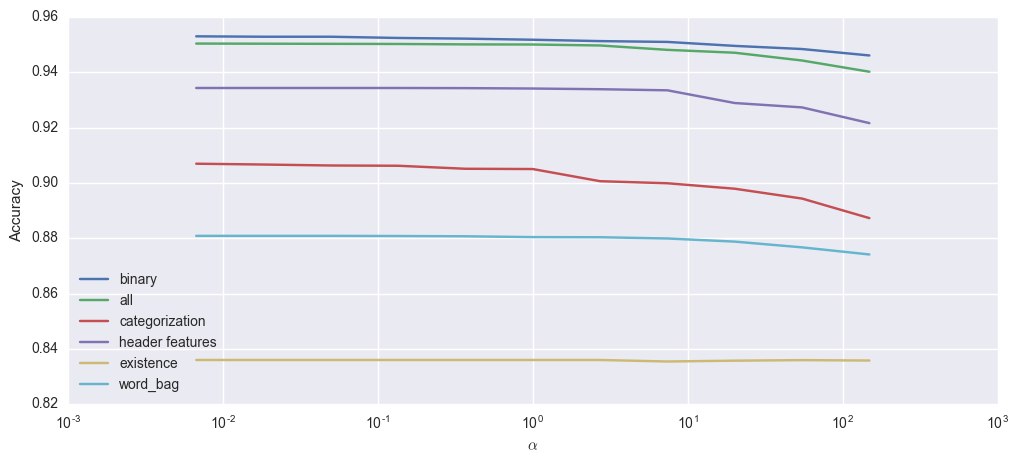

In [19]:
def test_alpha(a, X_train, X_test, y_train, y_test):
    nb = BernoulliNB(alpha = a, fit_prior = True)
    nb.fit(X_train, y_train)
    return nb.score(X_test, y_test)

def plot_categ(p):
    X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X[p], y)
    q = [numpy.exp(x) for x in numpy.linspace(-5, 5, 11)]
    w = [test_alpha(x, X_train, X_test, y_train, y_test) for x in q]
    return q, w

pyplot.xlabel(r'$\alpha$')
pyplot.ylabel('Accuracy')
pyplot.xscale('log')

subsets = {'all': X.columns, 'word_bag': word_bag, 'existence': existence, 'categorization': categorization, 'header features': header_features, 'binary': binary}
for name, categ in subsets.iteritems():
    q, w = plot_categ(categ)
    pyplot.plot(q, w, label = name)
    
pyplot.legend(loc = 0)
pyplot.savefig('informe/figures/bayes.png', bbox_inches = 'tight')

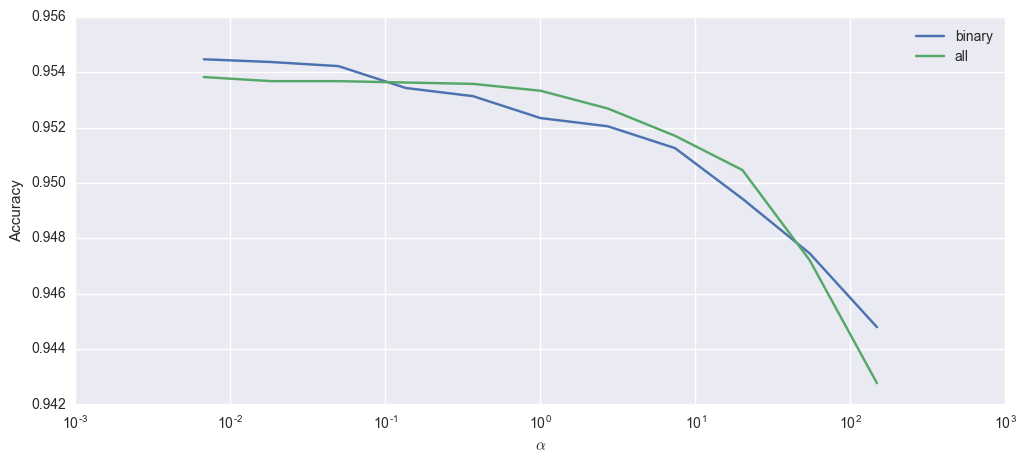

In [18]:
def test_alpha(a, X_train, X_test, y_train, y_test):
    nb = BernoulliNB(alpha = a, fit_prior = True)
    nb.fit(X_train, y_train)
    return nb.score(X_test, y_test)

def plot_categ(p):
    X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X[p], y)
    q = [numpy.exp(x) for x in numpy.linspace(-5, 5, 11)]
    w = [test_alpha(x, X_train, X_test, y_train, y_test) for x in q]
    return q, w

pyplot.xlabel(r'$\alpha$')
pyplot.ylabel('Accuracy')
pyplot.xscale('log')

subsets = {'all': X.columns, 'binary': binary}
for name, categ in subsets.iteritems():
    q, w = plot_categ(categ)
    pyplot.plot(q, w, label = name)
    
pyplot.legend(loc = 0)

In [24]:
nb = BernoulliNB(alpha = 1, fit_prior = True)
nb.fit(X_train, y_train)

sklearn.metrics.roc_curve(y_test, nb.predict(X_test))

(array([ 0.       ,  0.0829484,  1.       ]),
 array([ 0.        ,  0.98699752,  1.        ]),
 array([2, 1, 0]))

In [28]:
y_pred = nb.predict(X_test)


In [53]:
nb = BernoulliNB(alpha = 1, fit_prior = True)
data(cross_val_score(nb, X[binary], y, cv = folds))

mean    0.952185
std     0.001748
min     0.948765
50%     0.952160
max     0.955185
dtype: float64


array([ 0.95135802,  0.95333333,  0.94876543,  0.95518519,  0.95209877,
        0.95283951,  0.95222222,  0.95111111,  0.9537037 ,  0.95123457])

In [62]:
nb = BernoulliNB(alpha = 1, fit_prior = True)
nb.fit(X_train, y_train)

BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True)

In [74]:
(nb.predict_proba(X_test).argmax(axis = 1)== nb.predict(X_test)).all()

True

In [56]:
(a == y).mean()

0.95120987654320988

## Neighbours

In [12]:
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid

### K Nearest Neighbors

In [29]:
folds = 3

In [30]:
kn = KNeighborsClassifier(5, weights = 'uniform')
data(cross_val_score(kn, X, y, cv = folds))

KeyboardInterrupt: 

#### Grid Search

In [43]:
Xs = X.sample(frac = 1/10, random_state = 0)
ys = y.sample(frac = 1/10, random_state = 0)

assert (Xs.index == ys.index).all()

In [52]:
from sklearn.grid_search import GridSearchCV

cvn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid = {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
    },
    verbose = 2
)
cvn.fit(Xs, ys)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ......................... n_neighbors=3, weights=uniform -   2.6s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ......................... n_neighbors=3, weights=uniform -   2.6s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ......................... n_neighbors=3, weights=uniform -   2.4s
[CV] n_neighbors=3, weights=distance .................................
[CV] ........................ n_neighbors=3, weights=distance -   2.6s
[CV] n_neighbors=3, weights=distance .................................
[CV] ........................ n_neighbors=3, weights=distance -   2.6s
[CV] n_neighbors=3, weights=distance .................................
[CV] ........................ n_neighbors=3, weights=distance -   2.3s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ............

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   50.0s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [55]:
cvn.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')

In [56]:
cvn.grid_scores_

[mean: 0.91765, std: 0.00451, params: {'n_neighbors': 3, 'weights': 'uniform'},
 mean: 0.92062, std: 0.00408, params: {'n_neighbors': 3, 'weights': 'distance'},
 mean: 0.90988, std: 0.00276, params: {'n_neighbors': 5, 'weights': 'uniform'},
 mean: 0.91778, std: 0.00214, params: {'n_neighbors': 5, 'weights': 'distance'},
 mean: 0.90815, std: 0.00134, params: {'n_neighbors': 7, 'weights': 'uniform'},
 mean: 0.91679, std: 0.00048, params: {'n_neighbors': 7, 'weights': 'distance'}]

In [49]:
cv.best_score_

0.92061728395061726

In [50]:
from sklearn.grid_search import GridSearchCV

cv = GridSearchCV(
    KNeighborsClassifier(),
    param_grid = {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
    },
    verbose = 2
)
cv.fit(sklearn.preprocessing.scale(Xs), ys)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ......................... n_neighbors=3, weights=uniform -  14.5s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ......................... n_neighbors=3, weights=uniform -  14.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ......................... n_neighbors=3, weights=uniform -  19.0s
[CV] n_neighbors=3, weights=distance .................................
[CV] ........................ n_neighbors=3, weights=distance -  14.5s
[CV] n_neighbors=3, weights=distance .................................
[CV] ........................ n_neighbors=3, weights=distance -  14.1s
[CV] n_neighbors=3, weights=distance .................................
[CV] ........................ n_neighbors=3, weights=distance -  19.6s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ............

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  5.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [51]:
cv.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='distance')

In [18]:
kn = KNeighborsClassifier(5, weights = 'uniform')


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [19]:
kn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [72]:
%timeit kn.score(X_test, y_test)

1 loop, best of 3: 52.8 s per loop


In [15]:
kn4 = KNeighborsClassifier(4, weights = 'uniform')
# data(cross_val_score(kn, X, y, cv = folds))

In [16]:
kn4.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [17]:
%timeit kn4.score(X_test, y_test)

1 loop, best of 3: 53 s per loop


In [20]:
kn.score(X_test, y_test)

0.95703703703703702

In [21]:
kn4.score(X_test, y_test)

0.95772839506172835

### Nearest Centroid

In [17]:
nc = NearestCentroid()
data(cross_val_score(nc, X, y, cv = folds))

mean    0.471185
std     0.003756
min     0.463951
50%     0.471173
max     0.476420
dtype: float64


array([ 0.47358025,  0.46395062,  0.47111111,  0.46703704,  0.47123457,
        0.46987654,  0.47641975,  0.47395062,  0.46987654,  0.47481481])

## Support Vector Machines

In [13]:
from sklearn.svm import SVC, LinearSVC

### Linear kernel

In [12]:
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [13]:
lsvc.score(X_test, y_test)

0.97511111111111115

In [14]:
primalsvc = LinearSVC(dual = False).fit(X_train, y_train)
primalsvc.score(X_test, y_test)

0.9790123456790123

In [12]:
data(cross_val_score(LinearSVC(dual = False), X, y, cv = folds))

mean    0.968210
std     0.002235
min     0.964938
50%     0.968333
max     0.973457
dtype: float64


array([ 0.96851852,  0.96703704,  0.96691358,  0.96876543,  0.9691358 ,
        0.96666667,  0.97345679,  0.96839506,  0.96493827,  0.9682716 ])

### Pipelining some normalization

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, FunctionTransformer

In [13]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('vector', LinearSVC(dual = False))
])
pipe.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [19]:
pipe.score(X_test, y_test)

0.99244444444444446

In [14]:
pipe = Pipeline([
    ('transform', FunctionTransformer(numpy.log1p)),
    ('scale', StandardScaler()),
    ('vector', LinearSVC(dual = False))
])
# pipe.fit(X_train, y_train)
# pipe.score(X_test, y_test)

In [15]:
pipe.__class__.__name__

'Pipeline'

### Estimating C

In [15]:
from sklearn.grid_search import GridSearchCV

In [57]:
estimator = Pipeline([
    ('scale', StandardScaler()),
    ('vector', LinearSVC(dual = False, random_state = 0))
])

gs = GridSearchCV(
    estimator,
    {
        'vector__loss': ['squared_hinge'],
        'vector__penalty': ['l1', 'l2'],
        'vector__C': [.01, .1, 1, 10, 100]
    },
    cv = 3,
    refit = False,
    verbose = 2
)

In [58]:
Xsample = X.sample(frac = 1/10, random_state = 0)
ysample = y.sample(frac = 1/10, random_state = 0)
assert (Xsample.index == ysample.index).all()

gs.fit(Xsample, ysample)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] vector__loss=squared_hinge, vector__penalty=l1, vector__C=0.01 ..
[CV]  vector__loss=squared_hinge, vector__penalty=l1, vector__C=0.01 -   2.4s
[CV] vector__loss=squared_hinge, vector__penalty=l1, vector__C=0.01 ..
[CV]  vector__loss=squared_hinge, vector__penalty=l1, vector__C=0.01 -   3.7s
[CV] vector__loss=squared_hinge, vector__penalty=l1, vector__C=0.01 ..
[CV]  vector__loss=squared_hinge, vector__penalty=l1, vector__C=0.01 -   1.8s
[CV] vector__loss=squared_hinge, vector__penalty=l2, vector__C=0.01 ..
[CV]  vector__loss=squared_hinge, vector__penalty=l2, vector__C=0.01 -   1.1s
[CV] vector__loss=squared_hinge, vector__penalty=l2, vector__C=0.01 ..
[CV]  vector__loss=squared_hinge, vector__penalty=l2, vector__C=0.01 -   1.1s
[CV] vector__loss=squared_hinge, vector__penalty=l2, vector__C=0.01 ..
[CV]  vector__loss=squared_hinge, vector__penalty=l2, vector__C=0.01 -   1.1s
[CV] vector__loss=squared_hinge, vector__pena

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('vector', LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'vector__loss': ['squared_hinge'], 'vector__penalty': ['l1', 'l2'], 'vector__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=False, scoring=None, verbose=2)

In [59]:
gs.best_params_

{'vector__C': 0.1, 'vector__loss': 'squared_hinge', 'vector__penalty': 'l1'}

In [60]:
gs.grid_scores_

[mean: 0.97864, std: 0.00310, params: {'vector__loss': 'squared_hinge', 'vector__penalty': 'l1', 'vector__C': 0.01},
 mean: 0.98519, std: 0.00052, params: {'vector__loss': 'squared_hinge', 'vector__penalty': 'l2', 'vector__C': 0.01},
 mean: 0.98556, std: 0.00181, params: {'vector__loss': 'squared_hinge', 'vector__penalty': 'l1', 'vector__C': 0.1},
 mean: 0.98284, std: 0.00114, params: {'vector__loss': 'squared_hinge', 'vector__penalty': 'l2', 'vector__C': 0.1},
 mean: 0.98296, std: 0.00160, params: {'vector__loss': 'squared_hinge', 'vector__penalty': 'l1', 'vector__C': 1},
 mean: 0.98136, std: 0.00114, params: {'vector__loss': 'squared_hinge', 'vector__penalty': 'l2', 'vector__C': 1},
 mean: 0.98259, std: 0.00297, params: {'vector__loss': 'squared_hinge', 'vector__penalty': 'l1', 'vector__C': 10},
 mean: 0.98198, std: 0.00149, params: {'vector__loss': 'squared_hinge', 'vector__penalty': 'l2', 'vector__C': 10},
 mean: 0.98296, std: 0.00181, params: {'vector__loss': 'squared_hinge', 'vec

In [61]:
estimator = Pipeline([
    ('scale', StandardScaler()),
    ('vector', LinearSVC(dual = True, random_state = 0))
])

gs2 = GridSearchCV(
    estimator,
    {
        'vector__loss': ['hinge'],
        'vector__penalty': ['l2'],
        'vector__C': [.01, .1, 1, 10, 100]
    },
    cv = 3,
    refit = False,
    verbose = 2
)
gs2.fit(Xsample, ysample)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] vector__loss=hinge, vector__penalty=l2, vector__C=0.01 ..........
[CV] . vector__loss=hinge, vector__penalty=l2, vector__C=0.01 -   0.7s
[CV] vector__loss=hinge, vector__penalty=l2, vector__C=0.01 ..........
[CV] . vector__loss=hinge, vector__penalty=l2, vector__C=0.01 -   0.7s
[CV] vector__loss=hinge, vector__penalty=l2, vector__C=0.01 ..........
[CV] . vector__loss=hinge, vector__penalty=l2, vector__C=0.01 -   0.7s
[CV] vector__loss=hinge, vector__penalty=l2, vector__C=0.1 ...........
[CV] .. vector__loss=hinge, vector__penalty=l2, vector__C=0.1 -   0.7s
[CV] vector__loss=hinge, vector__penalty=l2, vector__C=0.1 ...........
[CV] .. vector__loss=hinge, vector__penalty=l2, vector__C=0.1 -   0.8s
[CV] vector__loss=hinge, vector__penalty=l2, vector__C=0.1 ...........
[CV] .. vector__loss=hinge, vector__penalty=l2, vector__C=0.1 -   0.7s
[CV] vector__loss=hinge, vector__penalty=l2, vector__C=1 .............
[CV] .... vector_

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   10.9s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('vector', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'vector__loss': ['hinge'], 'vector__penalty': ['l2'], 'vector__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=False, scoring=None, verbose=2)

In [63]:
gs2.best_params_

{'vector__C': 0.01, 'vector__loss': 'hinge', 'vector__penalty': 'l2'}

In [64]:
gs2.grid_scores_

[mean: 0.98506, std: 0.00227, params: {'vector__loss': 'hinge', 'vector__penalty': 'l2', 'vector__C': 0.01},
 mean: 0.98284, std: 0.00106, params: {'vector__loss': 'hinge', 'vector__penalty': 'l2', 'vector__C': 0.1},
 mean: 0.97840, std: 0.00251, params: {'vector__loss': 'hinge', 'vector__penalty': 'l2', 'vector__C': 1},
 mean: 0.97901, std: 0.00274, params: {'vector__loss': 'hinge', 'vector__penalty': 'l2', 'vector__C': 10},
 mean: 0.97901, std: 0.00274, params: {'vector__loss': 'hinge', 'vector__penalty': 'l2', 'vector__C': 100}]

In [41]:
pandas.DataFrame.from_dict(gs.grid_scores_)

,parameters,mean_validation_score,cv_validation_scores
0,"{u'vector__loss': u'squared_hinge', u'vector__...",0.978642,"[0.974453905961, 0.981851851852, 0.979622082253]"
1,"{u'vector__loss': u'squared_hinge', u'vector__...",0.986173,"[0.984450203628, 0.987407407407, 0.986661726565]"
2,"{u'vector__loss': u'squared_hinge', u'vector__...",0.985556,"[0.983339503887, 0.985555555556, 0.987773249352]"
3,"{u'vector__loss': u'squared_hinge', u'vector__...",0.983951,"[0.982228804147, 0.984074074074, 0.985550203779]"
4,"{u'vector__loss': u'squared_hinge', u'vector__...",0.983827,"[0.981118104406, 0.983703703704, 0.986661726565]"
5,"{u'vector__loss': u'squared_hinge', u'vector__...",0.982593,"[0.981118104406, 0.982222222222, 0.984438680993]"
6,"{u'vector__loss': u'squared_hinge', u'vector__...",0.982963,"[0.980747871159, 0.981851851852, 0.98629121897]"
7,"{u'vector__loss': u'squared_hinge', u'vector__...",0.982716,"[0.980377637912, 0.982222222222, 0.985550203779]"
8,"{u'vector__loss': u'squared_hinge', u'vector__...",0.984198,"[0.981118104406, 0.984814814815, 0.986661726565]"
9,"{u'vector__loss': u'squared_hinge', u'vector__...",0.982593,"[0.980377637912, 0.982222222222, 0.985179696184]"


In [20]:
estimator = Pipeline([
    ('scale', StandardScaler()),
    ('vector', LinearSVC(dual = False, random_state = 0))
])

gs2 = GridSearchCV(
    estimator,
    {
        'vector__penalty': ['l1'],
        'vector__C': [1, 10, 25]
    },
    cv = 3,
    refit = False,
    verbose = 2
)
gs2.fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] vector__penalty=l1, vector__C=1 .................................
[CV] ........................ vector__penalty=l1, vector__C=1 - 2.0min
[CV] vector__penalty=l1, vector__C=1 .................................
[CV] ........................ vector__penalty=l1, vector__C=1 - 1.9min
[CV] vector__penalty=l1, vector__C=1 .................................
[CV] ........................ vector__penalty=l1, vector__C=1 - 1.8min
[CV] vector__penalty=l1, vector__C=10 ................................
[CV] ....................... vector__penalty=l1, vector__C=10 - 2.6min
[CV] vector__penalty=l1, vector__C=10 ................................
[CV] ....................... vector__penalty=l1, vector__C=10 - 2.4min
[CV] vector__penalty=l1, vector__C=10 ................................
[CV] ....................... vector__penalty=l1, vector__C=10 - 2.4min
[CV] vector__penalty=l1, vector__C=25 ................................
[CV] .............

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 21.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('vector', LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'vector__penalty': ['l1'], 'vector__C': [1, 10, 25]},
       pre_dispatch='2*n_jobs', refit=False, scoring=None, verbose=2)

In [23]:
gs2.best_params_

{'vector__C': 1, 'vector__penalty': 'l1'}

In [24]:
gs2.grid_scores_

[mean: 0.99258, std: 0.00024, params: {'vector__penalty': 'l1', 'vector__C': 1},
 mean: 0.99241, std: 0.00024, params: {'vector__penalty': 'l1', 'vector__C': 10},
 mean: 0.99237, std: 0.00026, params: {'vector__penalty': 'l1', 'vector__C': 25}]

In [51]:
gs.best_params_

{'vector__C': 0.01, 'vector__loss': 'squared_hinge', 'vector__penalty': 'l2'}

In [52]:
gs2.best_params_

{'vector__C': 0.01, 'vector__loss': 'hinge', 'vector__penalty': 'l2'}

### Polynomial kernel

In [66]:
psvc = SVC(kernel = 'poly')
psvc.fit(Xsample, ysample)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [67]:
psvc.score(Xsample, ysample)

0.96209876543209871

In [69]:
Xsample = X.sample(frac = 1/20, random_state = 0)
ysample = y.sample(frac = 1/20, random_state = 0)

assert (Xsample.index == ysample.index).all()

In [70]:
estimator = Pipeline([
    ('scale', StandardScaler()),
    ('vector', SVC(kernel = 'poly', random_state = 0))
])

gs = GridSearchCV(
    estimator,
    {
        'vector__C': [.01, .1, 1, 10, 100],
        'vector__degree': [2, 3],
    },
    cv = 3,
    refit = False,
    verbose = 2
)
gs.fit(Xsample, ysample)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] vector__degree=2, vector__C=0.01 ................................
[CV] ....................... vector__degree=2, vector__C=0.01 -  13.0s
[CV] vector__degree=2, vector__C=0.01 ................................
[CV] ....................... vector__degree=2, vector__C=0.01 -  12.9s
[CV] vector__degree=2, vector__C=0.01 ................................
[CV] ....................... vector__degree=2, vector__C=0.01 -  12.9s
[CV] vector__degree=3, vector__C=0.01 ................................
[CV] ....................... vector__degree=3, vector__C=0.01 -  12.9s
[CV] vector__degree=3, vector__C=0.01 ................................
[CV] ....................... vector__degree=3, vector__C=0.01 -  13.0s
[CV] vector__degree=3, vector__C=0.01 ................................
[CV] ....................... vector__degree=3, vector__C=0.01 -  12.7s
[CV] vector__degree=2, vector__C=0.1 .................................
[CV] ...........

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('vector', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'vector__degree': [2, 3], 'vector__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=False, scoring=None, verbose=2)

In [71]:
gs.best_params_

{'vector__C': 10, 'vector__degree': 2}

In [72]:
gs.grid_scores_

[mean: 0.57975, std: 0.01614, params: {'vector__degree': 2, 'vector__C': 0.01},
 mean: 0.55037, std: 0.00939, params: {'vector__degree': 3, 'vector__C': 0.01},
 mean: 0.94000, std: 0.00682, params: {'vector__degree': 2, 'vector__C': 0.1},
 mean: 0.88370, std: 0.01782, params: {'vector__degree': 3, 'vector__C': 0.1},
 mean: 0.95679, std: 0.00635, params: {'vector__degree': 2, 'vector__C': 1},
 mean: 0.94691, std: 0.00609, params: {'vector__degree': 3, 'vector__C': 1},
 mean: 0.98420, std: 0.00194, params: {'vector__degree': 2, 'vector__C': 10},
 mean: 0.96247, std: 0.00286, params: {'vector__degree': 3, 'vector__C': 10},
 mean: 0.98370, std: 0.00264, params: {'vector__degree': 2, 'vector__C': 100},
 mean: 0.98420, std: 0.00140, params: {'vector__degree': 3, 'vector__C': 100}]

In [78]:
gsplus = GridSearchCV(
    estimator,
    {
        'vector__C': [.001, 1000],
        'vector__degree': [2, 3],
    },
    cv = 3,
    refit = False,
    verbose = 2
)
gsplus.fit(Xsample, ysample)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] vector__degree=2, vector__C=0.001 ...............................
[CV] ...................... vector__degree=2, vector__C=0.001 -  13.6s
[CV] vector__degree=2, vector__C=0.001 ...............................
[CV] ...................... vector__degree=2, vector__C=0.001 -  13.4s
[CV] vector__degree=2, vector__C=0.001 ...............................
[CV] ...................... vector__degree=2, vector__C=0.001 -  13.4s
[CV] vector__degree=3, vector__C=0.001 ...............................
[CV] ...................... vector__degree=3, vector__C=0.001 -  13.3s
[CV] vector__degree=3, vector__C=0.001 ...............................
[CV] ...................... vector__degree=3, vector__C=0.001 -  13.4s
[CV] vector__degree=3, vector__C=0.001 ...............................
[CV] ...................... vector__degree=3, vector__C=0.001 -  13.4s
[CV] vector__degree=2, vector__C=1000 ................................
[CV] ............

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('vector', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'vector__degree': [2, 3], 'vector__C': [0.001, 1000]},
       pre_dispatch='2*n_jobs', refit=False, scoring=None, verbose=2)

In [79]:
gsplus.best_params_

{'vector__C': 1000, 'vector__degree': 2}

In [80]:
gsplus.grid_scores_ + gs.grid_scores_

[mean: 0.50222, std: 0.00000, params: {'vector__degree': 2, 'vector__C': 0.001},
 mean: 0.50222, std: 0.00000, params: {'vector__degree': 3, 'vector__C': 0.001},
 mean: 0.98222, std: 0.00277, params: {'vector__degree': 2, 'vector__C': 1000},
 mean: 0.98222, std: 0.00277, params: {'vector__degree': 3, 'vector__C': 1000},
 mean: 0.57975, std: 0.01614, params: {'vector__degree': 2, 'vector__C': 0.01},
 mean: 0.55037, std: 0.00939, params: {'vector__degree': 3, 'vector__C': 0.01},
 mean: 0.94000, std: 0.00682, params: {'vector__degree': 2, 'vector__C': 0.1},
 mean: 0.88370, std: 0.01782, params: {'vector__degree': 3, 'vector__C': 0.1},
 mean: 0.95679, std: 0.00635, params: {'vector__degree': 2, 'vector__C': 1},
 mean: 0.94691, std: 0.00609, params: {'vector__degree': 3, 'vector__C': 1},
 mean: 0.98420, std: 0.00194, params: {'vector__degree': 2, 'vector__C': 10},
 mean: 0.96247, std: 0.00286, params: {'vector__degree': 3, 'vector__C': 10},
 mean: 0.98370, std: 0.00264, params: {'vector__de

### rbf kernel

In [81]:
estimator = Pipeline([
    ('scale', StandardScaler()),
    ('vector', SVC(kernel = 'rbf', random_state = 0))
])

gsr = GridSearchCV(
    estimator,
    {
        'vector__C': [.01, .1, 1, 10, 100, 1000]
    },
    cv = 3,
    refit = False,
    verbose = 2
)
gsr.fit(Xsample, ysample)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] vector__C=0.01 ..................................................
[CV] ......................................... vector__C=0.01 -  13.8s
[CV] vector__C=0.01 ..................................................
[CV] ......................................... vector__C=0.01 -  13.5s
[CV] vector__C=0.01 ..................................................
[CV] ......................................... vector__C=0.01 -  13.5s
[CV] vector__C=0.1 ...................................................
[CV] .......................................... vector__C=0.1 -   6.9s
[CV] vector__C=0.1 ...................................................
[CV] .......................................... vector__C=0.1 -   7.3s
[CV] vector__C=0.1 ...................................................
[CV] .......................................... vector__C=0.1 -   6.9s
[CV] vector__C=1 .....................................................
[CV] ............

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('vector', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'vector__C': [0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=False, scoring=None, verbose=2)

In [82]:
gsr.best_params_

{'vector__C': 100}

In [83]:
gsr.grid_scores_

[mean: 0.87605, std: 0.00817, params: {'vector__C': 0.01},
 mean: 0.92864, std: 0.01347, params: {'vector__C': 0.1},
 mean: 0.97531, std: 0.00344, params: {'vector__C': 1},
 mean: 0.98222, std: 0.00060, params: {'vector__C': 10},
 mean: 0.98272, std: 0.00252, params: {'vector__C': 100},
 mean: 0.98222, std: 0.00277, params: {'vector__C': 1000}]

## Voting Classifier

In [11]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid

### With a Decision Tree

In [15]:
vc = VotingClassifier(
    [
        ('tree', DecisionTreeClassifier(max_features = 'sqrt', max_depth = 5)),
        ('bayes', BernoulliNB()),
        # ('vector', SVC(kernel = 'linear', probability = True)),
        ('neighbours', KNeighborsClassifier(5, weights = 'uniform'))
    ],
    voting = 'soft'
)
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')), ('ba...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))],
         voting='soft', weights=None)

In [16]:
vc.score(X_test, y_test)

0.97990123456790124

### With a Random Forest

In [25]:
vc = VotingClassifier(
    [
        ('forest', RandomForestClassifier(n_estimators = 40)),
        ('bayes', BernoulliNB()),
        # ('neighbours', KNeighborsClassifier(5, weights = 'uniform'))
    ],
    voting = 'soft'
)
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('bayes', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))],
         voting='soft', weights=None)

In [26]:
vc.score(X_test, y_test)

0.97851851851851857

In [24]:
rf = RandomForestClassifier(n_estimators = 40, criterion = 'gini')
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
rf.score(X_test, y_test)

0.99683950617283945

# Principal Component Analysis

In [11]:
1

1

In [12]:
from sklearn.decomposition import PCA, RandomizedPCA

In [24]:
pca = PCA(n_components = numpy.ceil(numpy.sqrt(X.shape[1])))
fp = pca.fit_transform(X.sample(X.shape[1]))

In [26]:
pca.components_

array([[  1.22524993e-05,   5.71667241e-05,   5.01140314e-06, ...,
         -5.05746857e-07,  -5.23525508e-07,  -1.53505500e-06],
       [  2.07577085e-04,  -2.38671918e-04,   1.32994330e-05, ...,
         -7.53258790e-06,   2.02788081e-06,  -1.05069041e-05],
       [  2.16250770e-04,   1.68193168e-03,   4.08976939e-05, ...,
         -1.56123410e-05,  -2.67864733e-06,  -8.72158215e-06],
       ..., 
       [  7.77031806e-03,   9.14940741e-04,   3.10849581e-02, ...,
          1.07420120e-05,  -1.14503298e-03,  -4.63228658e-04],
       [ -8.61278655e-03,   4.03840107e-03,  -1.84458399e-01, ...,
          3.50899101e-04,   2.35146761e-04,  -1.45584748e-03],
       [  1.73388568e-02,   1.23569843e-03,  -8.46029310e-02, ...,
         -1.22839843e-04,   9.52728256e-04,  -1.16880216e-05]])

In [36]:
pca.explained_variance_ratio_.cumsum()

array([ 0.98589314,  0.99676131,  0.9994246 ,  0.99967968,  0.99986566,
        0.99991658,  0.99994384,  0.99995886,  0.99996959,  0.99997589,
        0.99997973,  0.99998301,  0.99998594,  0.99998776,  0.99998957,
        0.99999112,  0.9999926 ,  0.99999374,  0.99999457,  0.99999535,
        0.99999587,  0.99999634,  0.99999671,  0.99999701,  0.99999728,
        0.99999753,  0.99999776,  0.99999792,  0.99999807,  0.99999821,
        0.99999834,  0.99999845,  0.99999855])

In [25]:
fp

array([[  2.99403730e+03,   5.23470710e+02,   4.33833830e+01, ...,
          2.81167161e-01,  -2.82240149e+00,  -3.87890140e+00],
       [  3.11309225e+03,   2.49499446e+02,   1.06097727e+02, ...,
          5.83474947e-01,   4.50463007e-01,   2.92711226e+00],
       [ -6.38871837e+02,   7.05052922e+02,   1.21769999e+02, ...,
          5.24918733e+01,  -7.15207580e+00,   3.27837647e+01],
       ..., 
       [  2.66624391e+03,  -2.20252164e+02,   8.55621342e+01, ...,
         -7.22995003e-01,  -1.33330046e+00,   3.29646235e-02],
       [  3.62384868e+03,  -2.99568895e+01,   1.38615651e+02, ...,
         -4.07426132e+00,  -9.27417562e-01,   1.42269254e+00],
       [  1.85272251e+03,  -2.86221743e+02,   1.79010286e+01, ...,
         -9.35186439e-01,  -3.64181721e-01,   4.72014576e-01]])

In [10]:
rpca = RandomizedPCA(n_components = 3 * int(numpy.ceil(numpy.sqrt(X.shape[1]))), random_state = 0)
fpr = rpca.fit_transform(X)

NameError: name 'RandomizedPCA' is not defined

In [46]:
rpca.components_

array([[ -2.05162502e-06,   2.36404485e-05,  -2.64861672e-07, ...,
          7.61837491e-09,   8.09622764e-09,   1.72307363e-08],
       [ -8.84286313e-06,  -8.93584517e-05,  -4.53309653e-07, ...,
          1.48547032e-07,   1.98878820e-07,   2.62087185e-07],
       [ -8.38299924e-06,   8.40169125e-05,   1.90874004e-06, ...,
          2.64659407e-08,  -7.43523161e-08,  -4.61373578e-09],
       ..., 
       [ -1.37934447e-02,  -1.03957309e-02,   6.30458586e-02, ...,
          2.07893403e-03,   6.27302292e-03,   5.03634461e-03],
       [  5.42659372e-02,  -4.30943428e-02,   1.22493223e-03, ...,
         -1.53654704e-03,  -2.79661611e-03,   4.95579849e-03],
       [ -1.55946532e-02,  -4.85879567e-03,   7.30231978e-02, ...,
         -2.00039693e-03,  -1.79164029e-02,  -5.75955015e-03]])

In [47]:
rpca.explained_variance_ratio_.cumsum()

array([ 0.97203384,  0.99557176,  0.99951615,  0.99986639,  0.99996034,
        0.99998018,  0.99998117,  0.99998123,  0.99998124,  0.99998124,
        0.99998125,  0.99998125,  0.99998125,  0.99998125,  0.99998125,
        0.99998125,  0.99998125,  0.99998125,  0.99998125,  0.99998125,
        0.99998125,  0.99998125,  0.99998125,  0.99998125,  0.99998125,
        0.99998125,  0.99998125,  0.99998125,  0.99998125,  0.99998125,
        0.99998125,  0.99998125,  0.99998125])

In [48]:
fpr

array([[ -5.57242137e+03,  -6.97726614e+02,  -9.60935185e+01, ...,
          4.52502765e+00,   6.08651329e+00,   1.07627157e+01],
       [ -6.46434803e+03,  -5.22476422e+02,  -3.72675488e+01, ...,
          1.82724639e+00,   1.36608331e-01,  -3.02781270e+00],
       [ -5.20094135e+03,  -2.01173976e+02,  -1.22304939e+02, ...,
          3.47011293e+02,   2.54346861e+02,   1.31603200e+02],
       ..., 
       [ -3.95062820e+03,  -1.06299365e+02,  -1.22328880e+02, ...,
          8.45455705e+00,   9.26241540e+00,  -1.27657605e+01],
       [ -4.10767855e+03,  -2.32689062e+02,  -1.22326175e+02, ...,
         -2.22668376e+00,  -5.81971603e+00,   1.25110283e+00],
       [ -3.05985021e+03,  -1.18832227e+03,  -7.44872687e+01, ...,
         -1.04209771e+01,  -2.06468018e+01,  -1.92082303e+01]])

In [ ]:
df = pandas.concat(
    [
        pandas.DataFrame(fpr, index = X.index, columns = ['component' + str(x) for x in range(fpr.shape[1])]),
        y
    ],
    axis = 1
)

df.to_csv('dev/features_pc_plus.csv', index = True, header = True)

# Whitespace

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

